In [21]:
import warnings 
warnings.filterwarnings('ignore')

import sys, os 
sys.path.append(os.environ['TOOLS_PATH'])

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from datetime import datetime as dt 


import tools 
import dbloader as db 

from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.stattools import jarque_bera
import mplfinance as mpf 
from pykalman import KalmanFilter

loader = db.DBLoader()

In [22]:

symbol='BTCUSD'
start_date = dt(2014, 1, 1)
end_date = dt(2024, 1, 1)
btc=loader.load_data(symbol, loader.resolutions.RESOLUTION_D1, start_date=start_date, end_date=end_date)#[['Close']]
btc['log_returns'] = np.log(btc['Close']/btc['Close'].shift(1))


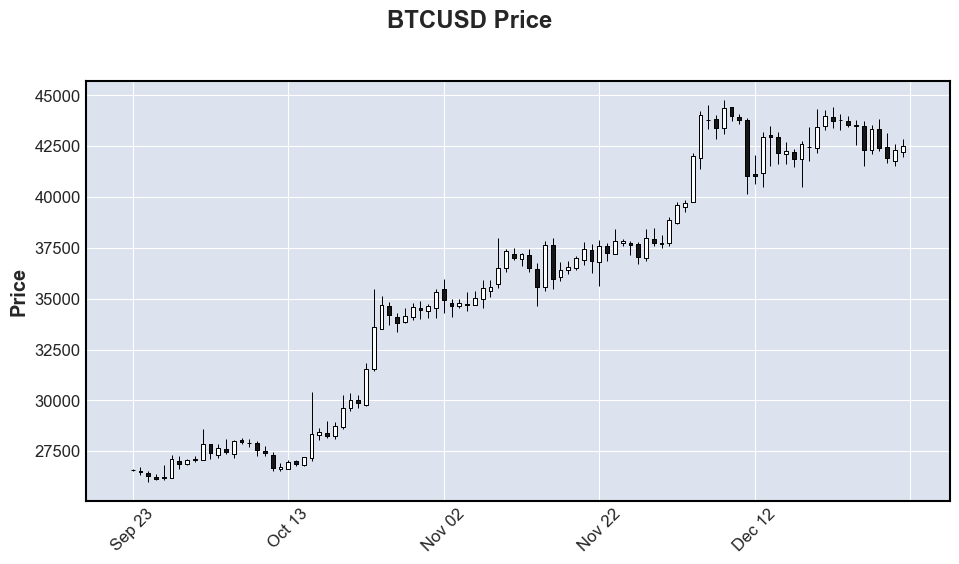

In [23]:
mpf.plot(btc.tail(100), figsize=(12, 6), title="BTCUSD Price", type='candle', )


In [24]:
def get_jb(data):
    if not isinstance(data, pd.Series):
        raise ValueError("Invalid input")
    
    jb, p, skew, kurt = jarque_bera(data)
    print(f"Jarque Bera Test Results: Test Statistic: {jb:.2f}, P-Value: {p:.5e}, Skew: {skew:.5f}, Kurt: {kurt:.5f}")
    if p < 0.05:
        print(f"Price series is normal. P: {p:.5e}")
    else:
        print(f"Price Series is NOT normal. P: {p:.5e}")

Jarque Bera Test Results: Test Statistic: nan, P-Value: nan, Skew: nan, Kurt: nan
Price Series is NOT normal. P: nan


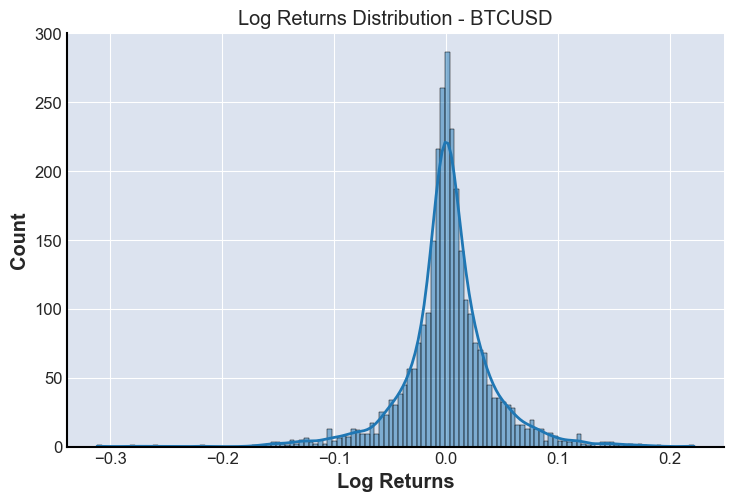

In [25]:

get_jb(btc['log_returns'])
sns.displot(btc['log_returns'], kde=True, height=5, aspect=1.5)
plt.xlabel('Log Returns')
plt.title('Log Returns Distribution - BTCUSD');

Text(0.5, 1.0, 'Mean-Spread ($)')

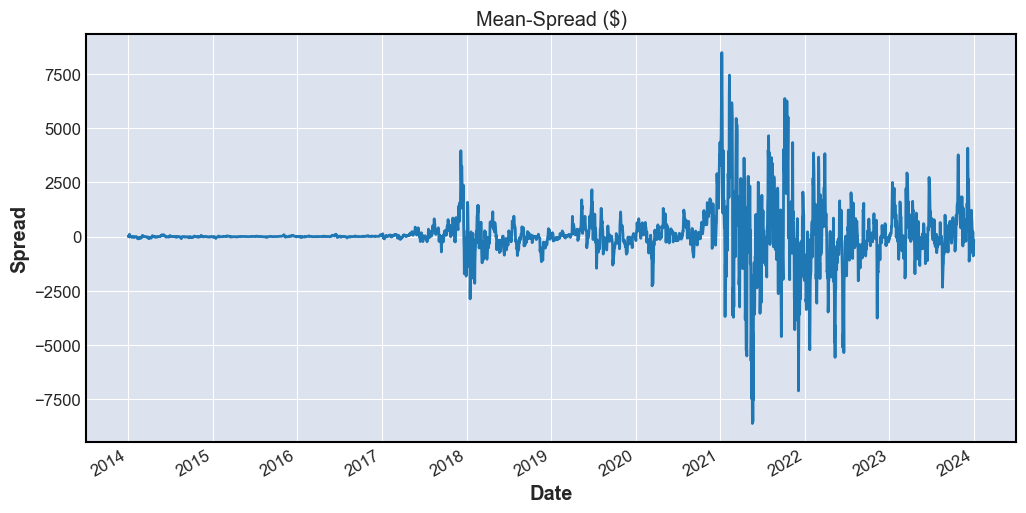

In [26]:

btc['mean'] = btc['Close'].ewm(span=10).mean()
btc['spread'] = btc['Close'] - btc['mean']
btc['spread_mean'] = btc['spread'].ewm(span=10).mean()
btc['spread_sdev'] = btc['spread'].ewm(span=10).std()
btc['z_score'] = (btc['spread'] - btc['spread_mean']) / btc['spread_sdev']

btc['spread'].plot(figsize=(12, 6))
plt.ylabel('Spread')
plt.title('Mean-Spread ($)')

In [27]:

# Test the spread for stationarity using ADF 
adf = adfuller(btc['Close'].dropna(), maxlag=1)
test_statistic, p_value, _, _, critical_value, _ = adf
print(f"ADF Result Parameters \n{adf}\n")

print(f"Test Statistic: {test_statistic:.4f}")

print(f"Critical Value: {critical_value['5%']:.4f}")

print(f"P-Value: {p_value*100:.4f}%")

ADF Result Parameters 
(-0.9712609521101027, 0.7636013878915888, 1, 2971, {'1%': -3.43255294814828, '5%': -2.862513318628595, '10%': -2.5672881236866054}, 48378.992272639516)

Test Statistic: -0.9713
Critical Value: -2.8625
P-Value: 76.3601%


In [28]:
# Print Stationarity 
def is_stationary(p_value):
    if p_value < 0.05: 
        print(f"Series is Stationary. (p-value {p_value*100:.4f}%)")
    else:
        print(f"Series is NOT Stationary. (p-value {p_value*100:.4f}%)")
    return 
is_stationary(p_value)

Series is NOT Stationary. (p-value 76.3601%)


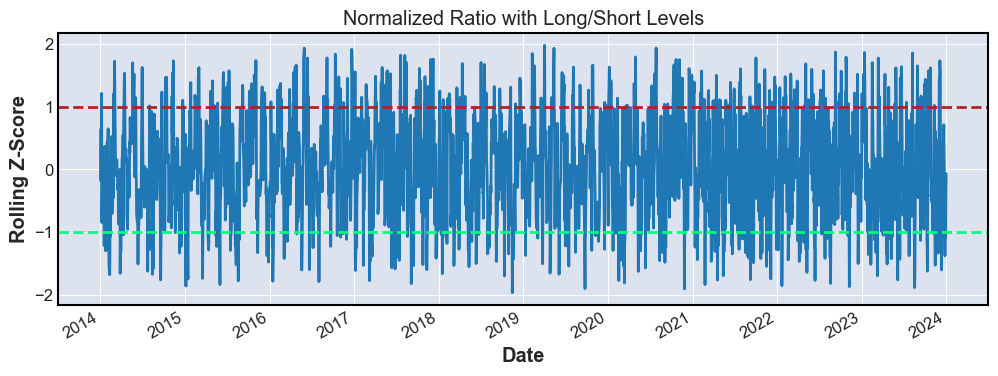

In [29]:
btc['z_score'].plot(figsize=(12, 4))
plt.axhline(1, color='firebrick', ls='--')
plt.axhline(-1, color = 'springgreen', ls='--')
plt.ylabel("Rolling Z-Score")
plt.title("Normalized Ratio with Long/Short Levels");

In [30]:
def build_signal(data, column_name, entry_mask, exit_mask, entry_signal, exit_signal):
    sig = data
    sig[column_name] = np.nan 
    sig.loc[entry_mask, column_name] = entry_signal 
    sig.loc[exit_mask, column_name] = exit_signal 
    sig[column_name] = sig[column_name].ffill()
    sig[column_name] = sig[column_name].fillna(0)
    return sig 

dataset=btc.copy()
dataset['z_up'] = 1 
dataset['z_down'] = -1


# Since the series is not stationary, we are more likely to benefit from trading on momentum instead of mean reversion 
# Also possible to add trend following filters
short_entry = (dataset['z_score'] <= dataset['z_down']) 
short_exit = (dataset['z_score'] >= 0)

long_entry = (dataset['z_score'] >= dataset['z_up']) 
long_exit = (dataset['z_score'] <= 0)

dataset = build_signal(data = dataset, column_name= 'long_pos', entry_mask=long_entry, exit_mask=long_exit, entry_signal= 1, exit_signal= 0)
dataset = build_signal(data = dataset, column_name= 'short_pos', entry_mask=short_entry, exit_mask = short_exit, entry_signal=-1, exit_signal=0)
dataset['total_pos'] = dataset['long_pos'] + dataset['short_pos']
dataset['signal'] = dataset['total_pos'] 

dataset.head()

,Open,High,Low,Close,Spread,log_returns,mean,spread,spread_mean,spread_sdev,z_score,z_up,z_down,long_pos,short_pos,total_pos,signal
Date,,,,,,,,,,,,,,,,,
2014-01-01,726.38,748.50,726.33,741.32,0,NaN,741.320000,0.000000,0.000000,NaN,NaN,1,-1,0.0,0.0,0.0,0.0
2014-01-02,741.00,799.89,740.17,792.53,0,0.066798,769.485500,23.044500,12.674475,16.294922,0.636396,1,-1,0.0,0.0,0.0,0.0
2014-01-03,792.53,818.47,765.00,785.00,0,-0.009547,775.722226,9.277774,11.309024,11.122159,-0.182631,1,-1,0.0,0.0,0.0,0.0
2014-01-06,905.34,990.00,888.00,935.21,0,0.175087,828.266342,106.943658,42.816375,53.040005,1.209036,1,-1,1.0,0.0,1.0,1.0
2014-01-07,935.21,944.00,780.00,797.30,0,-0.159540,819.376747,-22.076747,24.187325,54.638830,-0.846725,1,-1,0.0,0.0,0.0,0.0


Sharpe Daily: 0.072482, Sharpe Annual: 1.1506


Text(0.5, 1.0, 'Strategy Returns')

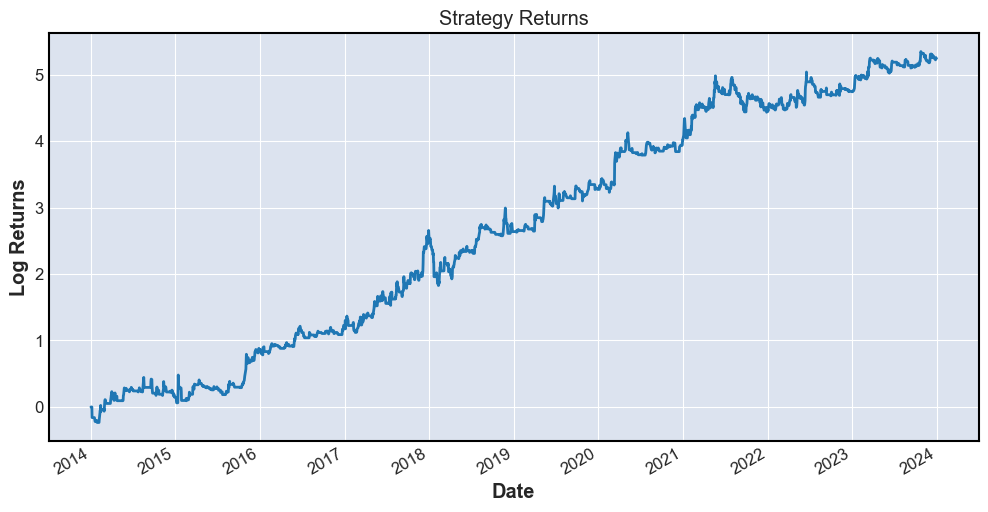

In [31]:
strategy = dataset['log_returns'] * dataset['signal'].shift(1) 
strategy.cumsum().plot(figsize=(12, 6))

strategy_mean = strategy[strategy!=0].mean()
strategy_std = strategy[strategy!=0].std()

rf  = 0.05 
sharpe_daily = (strategy_mean - (rf/252)) / strategy_std 
sharpe_ann = (sharpe_daily * np.sqrt(252))
print(f"Sharpe Daily: {sharpe_daily:.5}, Sharpe Annual: {sharpe_ann:.5}")

plt.ylabel('Log Returns')
plt.title('Strategy Returns')

Text(0.5, 1.0, 'Benchmark vs Strategy Returns')

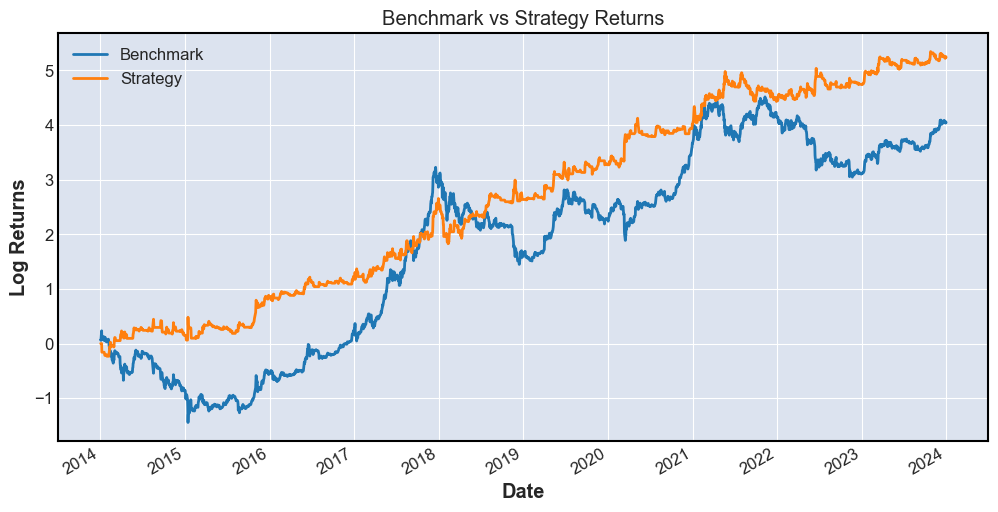

In [32]:
returns = pd.DataFrame(columns=['Benchmark','Strategy'])
returns['Benchmark'] = dataset['log_returns']
returns['Strategy'] = strategy 

returns.cumsum().plot(figsize=(12, 6))
plt.ylabel('Log Returns')
plt.title('Benchmark vs Strategy Returns')


Strategy Average Annual Returns: 52.41%
Benchmark Average Annual Returns: 40.49%


Text(0.5, 1.0, 'Annual Returns Comparison: Benchmark vs Strategy')

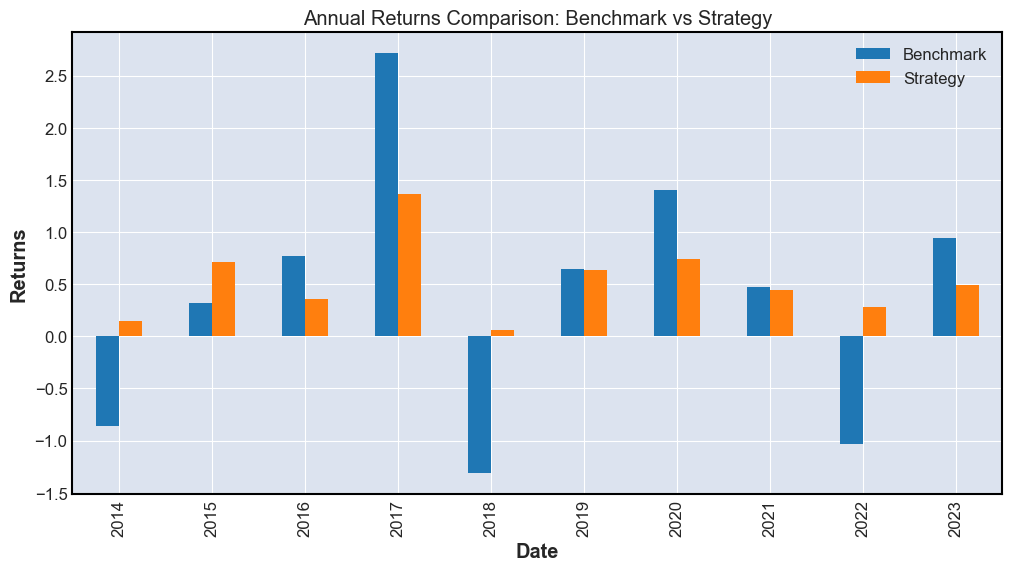

In [33]:
ann_returns = returns.groupby(returns.index.year).sum()
ann_returns.plot(kind='bar', figsize=(12, 6))
strategy_annual = ann_returns['Strategy'].mean()*100
benchmark_annual = ann_returns['Benchmark'].mean()*100
print(f"Strategy Average Annual Returns: {strategy_annual:.2f}%")
print(f"Benchmark Average Annual Returns: {benchmark_annual:.2f}%")
plt.ylabel('Returns')
plt.title('Annual Returns Comparison: Benchmark vs Strategy')